<div style="font-family: Arial, Helvetica, sans-serif;">
    <div style="display: flex;padding-top: 20px">
        <div><strong>Course:</strong> Statistical Learning</div>
    </div>
    <div style="display: flex;padding-top: 20px">
        <div style="padding-right: 10px;"><strong>Class:</strong> 22CNTTh</div>
        <div></div>
    </div>
    <div style="display: flex;padding-top: 20px">
        <div style="padding-right: 10px;"><strong>Group:</strong> ...</div>
    </div>
    <div>
        <div style="display: flex;padding-top: 20px">
            <div style="padding-right: 10px;"><strong>Members:</strong></div>
            <div></div>
        </div>
        <table style="font-size: 15px; display:flex;padding-top: 20px">
            <tr>
                <th>No.</th>
                <th>Student ID</th>
                <th>Name</th>
            </tr>
            <tr>
                <td>1</td>
                <td> 22127004 </td>
                <td style="text-align:left;">Trình Cao An</td>
            </tr>
            <tr>
                <td>2</td>
                <td>22127014</td>
                <td style="text-align:left;">Nguyễn Kim Anh</td>
            </tr>
            <tr>
                <td>3</td>
                <td> 22127214 </td>
                <td style="text-align:left;">Võ Thị Kim Khôi</td>
            </tr>
        </table>
    </div>
    <div style="font-size: 25px ;font-weight: 800; text-align: center;padding-top: 20px;">FINAL PROJECT</div>
    <div style="font-size: 20px ;font-weight: 800; text-align: center;padding-top: 20px;">VIETNAMESE STOCKINSIGHT - MODEL FINTUNING - XLM-Roberta</div>
</div>

# Mount Drive

In [21]:
# Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing packages

In [ ]:
!pip install py_vncorenlp

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=87ce36f80cc24e1881ba59348754c91869e63a4783c771aac2b406325d68499e
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

from collections import Counter
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import (
    AutoConfig,
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    HfArgumentParser,
    PretrainedConfig,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
    set_seed,
)

from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
import evaluate

# Loading dataset

In [ ]:
path = 'drive/MyDrive/statlearning/data/ner_dataset_splits'
raw_datasets = DatasetDict({
    "train": load_from_disk(f"{path}/train"),
    "validation": load_from_disk(f"{path}/validation"),
    "test": load_from_disk(f"{path}/test")
})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 84996
    })
    validation: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 10625
    })
    test: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source'],
        num_rows: 10625
    })
})

# Unique labels

In [ ]:
def get_all_labels(ds):
    counter = Counter()
    for split in ds:
        counter.update(label for example in ds[split] for label in example["labels"])
    return sorted(counter.keys())

In [ ]:
def sort_label_list_BIO(label_list):
  BI_pairs = []
  seen_i = set()
  for label in label_list:
    if label.startswith("B-"):
      entity = label[2:]
      i_label = f"I-{entity}"
      BI_pairs.append((label, i_label))
      seen_i.add(i_label)

  rest = [label for label in label_list if not label.startswith("B-") and label not in seen_i]

  sorted_list = []
  for b, i in sorted(BI_pairs):
    sorted_list.append(b)
    if i:
      sorted_list.append(i)
  sorted_list.extend(sorted(rest))

  return sorted_list

In [ ]:
# Collect all unique labels from the training dataset
list_labels = get_all_labels(raw_datasets)
expanded_labels = sort_label_list_BIO(list_labels)

id2label = {i: label for i, label in enumerate(expanded_labels)}
label2id = {label: i for i, label in enumerate(expanded_labels)}

print(id2label)
print(label2id)

{0: 'B-COMPANY', 1: 'I-COMPANY', 2: 'B-EVENT', 3: 'I-EVENT', 4: 'B-FIN_IND', 5: 'I-FIN_IND', 6: 'B-LAW', 7: 'I-LAW', 8: 'B-LOC', 9: 'I-LOC', 10: 'B-MBS', 11: 'I-MBS', 12: 'B-NUM', 13: 'I-NUM', 14: 'B-PERSON', 15: 'I-PERSON', 16: 'B-PRICE_ACTION', 17: 'I-PRICE_ACTION', 18: 'B-RISK', 19: 'I-RISK', 20: 'B-STOCK', 21: 'I-STOCK', 22: 'B-STRATEGY', 23: 'I-STRATEGY', 24: 'B-TIME', 25: 'I-TIME', 26: 'B-TITLE', 27: 'I-TITLE', 28: 'O'}
{'B-COMPANY': 0, 'I-COMPANY': 1, 'B-EVENT': 2, 'I-EVENT': 3, 'B-FIN_IND': 4, 'I-FIN_IND': 5, 'B-LAW': 6, 'I-LAW': 7, 'B-LOC': 8, 'I-LOC': 9, 'B-MBS': 10, 'I-MBS': 11, 'B-NUM': 12, 'I-NUM': 13, 'B-PERSON': 14, 'I-PERSON': 15, 'B-PRICE_ACTION': 16, 'I-PRICE_ACTION': 17, 'B-RISK': 18, 'I-RISK': 19, 'B-STOCK': 20, 'I-STOCK': 21, 'B-STRATEGY': 22, 'I-STRATEGY': 23, 'B-TIME': 24, 'I-TIME': 25, 'B-TITLE': 26, 'I-TITLE': 27, 'O': 28}


In [ ]:
def add_labels_id(batch):
    batch["labels_id"] = [
        [label2id[label] for label in labels] for labels in batch["labels"]
    ]
    return batch

new_raw_dataset = raw_datasets.map(add_labels_id, batched=True)

for idx in range(len(label2id)):
    label = [k for k, v in label2id.items() if v == idx][0]
    print(f"{idx}: {label}")

Map:   0%|          | 0/84996 [00:00<?, ? examples/s]

Map:   0%|          | 0/10625 [00:00<?, ? examples/s]

Map:   0%|          | 0/10625 [00:00<?, ? examples/s]

0: B-COMPANY
1: I-COMPANY
2: B-EVENT
3: I-EVENT
4: B-FIN_IND
5: I-FIN_IND
6: B-LAW
7: I-LAW
8: B-LOC
9: I-LOC
10: B-MBS
11: I-MBS
12: B-NUM
13: I-NUM
14: B-PERSON
15: I-PERSON
16: B-PRICE_ACTION
17: I-PRICE_ACTION
18: B-RISK
19: I-RISK
20: B-STOCK
21: I-STOCK
22: B-STRATEGY
23: I-STRATEGY
24: B-TIME
25: I-TIME
26: B-TITLE
27: I-TITLE
28: O


# Tokenize with XLM-Roberta

In [ ]:
model_checkpoint = "xlm-roberta-base"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
 print(tokenizer.model_max_length) # Chỉ để kiểm tra cho chắc chắn

512


In [ ]:
def tokenize_and_align_labels(examples):
    # Nếu phần tử đầu tiên là string, tách từ (split) thành list
    if isinstance(examples["tokens"][0], str):
        examples["tokens"] = [sent.split() for sent in examples["tokens"]]

    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    n_examples = len(examples["tokens"])
    n_encodings = len(tokenized_inputs["input_ids"])
    if n_examples != n_encodings:
        print("Batch size mismatch:", n_examples, n_encodings)
        print("tokens:", examples["tokens"][:2])
        print("labels_id:", examples["labels_id"][:2])
        raise ValueError("Batch size mismatch between input and tokenizer output.")

    labels = []
    for i, label in enumerate(examples["labels_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = new_raw_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    batch_size=32,
)

tokenized_datasets

Map:   0%|          | 0/84996 [00:00<?, ? examples/s]

Map:   0%|          | 0/10625 [00:00<?, ? examples/s]

Map:   0%|          | 0/10625 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'attention_mask'],
        num_rows: 84996
    })
    validation: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'attention_mask'],
        num_rows: 10625
    })
    test: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'attention_mask'],
        num_rows: 10625
    })
})

In [ ]:
# Save tokenized_datasets
path = '/content/drive/MyDrive/statlearning/xlm_roberta_tokenized_datasets'
tokenized_datasets.save_to_disk(path)

Saving the dataset (0/2 shards):   0%|          | 0/84996 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10625 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10625 [00:00<?, ? examples/s]

# Visualization for tokenization

## Label distribution

In [ ]:
label_counter = Counter()
for example in tokenized_datasets["train"]:
    for label_id in example["labels"]:
        if label_id != -100:
            label_counter[id2label[label_id]] += 1

entity_labels = [label for label in label_counter if label != 'O']
entity_counts = [label_counter[label] for label in entity_labels]

sorted_pairs = sorted(zip(entity_labels, entity_counts), key=lambda x: x[1], reverse=True)
entity_labels_sorted, entity_token_counts = zip(*sorted_pairs)

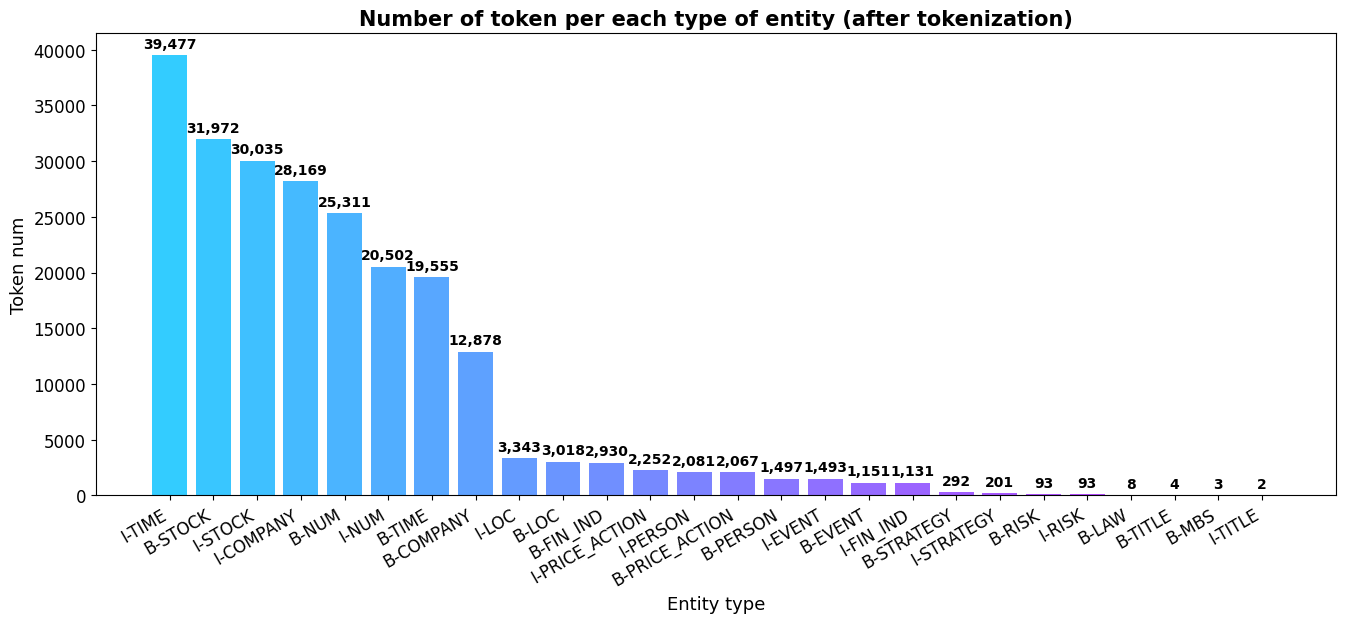

In [ ]:
plt.figure(figsize=(16, 6))
bars = plt.bar(entity_labels_sorted, entity_token_counts, color=plt.cm.cool(np.linspace(0.2, 0.8, len(entity_labels_sorted))))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(entity_token_counts)*0.01, f'{height:,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.ylabel('Token num', fontsize=13)
plt.xlabel('Entity type', fontsize=13)
plt.title('Number of token per each type of entity (after tokenization)', fontsize=15, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Type of entity

In [ ]:
entity_type_counter = Counter()
for example in tokenized_datasets["train"]:
    for label_id in example["labels"]:
        if label_id != -100:
            label = id2label[label_id]
            if label != 'O':
                entity_type = label.split('-')[1]
                entity_type_counter[entity_type] += 1

entity_types_sorted, entity_token_counts = zip(*sorted(entity_type_counter.items(), key=lambda x: x[1], reverse=True))

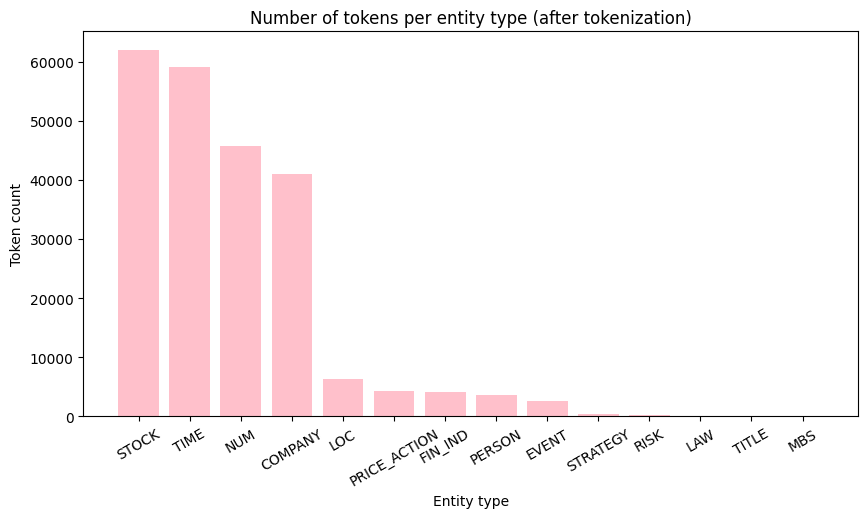

In [ ]:
plt.figure(figsize=(10,5))
bars = plt.bar(entity_types_sorted, entity_token_counts, color='pink')
plt.xticks(rotation=30)
plt.title('Number of tokens per entity type (after tokenization)')
plt.ylabel('Token count')
plt.xlabel('Entity type')
plt.show()

In [ ]:
# In top 5 entity type
print("Top 5 entity types:")
for etype, count in list(zip(entity_types_sorted, entity_token_counts))[:5]:
    print(f"{etype}: {count}")

# In bottom 5 entity type
print("\nBottom 5 entity types:")
for etype, count in list(zip(entity_types_sorted, entity_token_counts))[-5:]:
    print(f"{etype}: {count}")

Top 5 entity types:
STOCK: 62007
TIME: 59032
NUM: 45813
COMPANY: 41047
LOC: 6361

Bottom 5 entity types:
STRATEGY: 493
RISK: 186
LAW: 8
TITLE: 6
MBS: 3


# Modal configuration and Data Collator

In [ ]:
path = '/content/drive/MyDrive/statlearning/xlm_roberta_tokenized_datasets'

#load datasetdict
ds = DatasetDict({
    "train": load_from_disk(f"{path}/train"),
    "validation": load_from_disk(f"{path}/validation"),
    "test": load_from_disk(f"{path}/test")
})
ds

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'attention_mask'],
        num_rows: 84996
    })
    validation: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'attention_mask'],
        num_rows: 10625
    })
    test: Dataset({
        features: ['tokens', 'labels', 'original_text', 'source', 'labels_id', 'input_ids', 'attention_mask'],
        num_rows: 10625
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login() #token tương ứng với acc có repo

In [ ]:
model_checkpoint = "xlm-roberta-base"

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

## Class inheritance

In [ ]:
metric = evaluate.load("seqeval")

In [ ]:
def compute_metrics_seqeval(p):
    predictions, labels = p
    # Get the index that has highest proportion from logits to predict
    predictions = np.argmax(predictions, axis=2)

    # convert ID to label name, eliminate token padding -100
    true_predictions = [
        [expanded_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [expanded_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
import torch

# 1. GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Collect label id from train
all_label_ids = [
    label_id
    for example in ds["train"]
    for label_id in example["labels"]
    if label_id != -100
]

# 3. Đếm số lần xuất hiện
counts = Counter(all_label_ids)
num_labels = len(expanded_labels)

# 4. Tính class weights theo công thức logarit (ổn định và "hiền hòa" hơn)
class_weights = []
# Lặp qua các ID từ 0 đến num_labels-1
for label_id in range(num_labels):
    count = counts.get(label_id, 0)
    weight = 1.0 / np.log(count + 1.01) if count > 0 else 0.0
    class_weights.append(weight)

# 5. Chuẩn hóa và chuyển sang tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
class_weights_tensor = class_weights_tensor / class_weights_tensor.sum() * num_labels
class_weights_tensor = class_weights_tensor.to(device)

print("Class weights afer redefine:", dict(zip(expanded_labels, class_weights_tensor.cpu().numpy())))

Class weights afer redefine: {'B-COMPANY': np.float32(0.5385811), 'I-COMPANY': np.float32(0.49744064), 'B-EVENT': np.float32(0.7230235), 'I-EVENT': np.float32(0.6973089), 'B-FIN_IND': np.float32(0.63844645), 'I-FIN_IND': np.float32(0.7248243), 'B-LAW': np.float32(2.3184743), 'I-LAW': np.float32(0.0), 'B-LOC': np.float32(0.6360894), 'I-LOC': np.float32(0.6280751), 'B-MBS': np.float32(3.669942), 'I-MBS': np.float32(0.0), 'B-NUM': np.float32(0.50268924), 'I-NUM': np.float32(0.51335776), 'B-PERSON': np.float32(0.6970539), 'I-PERSON': np.float32(0.6670232), 'B-PRICE_ACTION': np.float32(0.6676127), 'I-PRICE_ACTION': np.float32(0.66020316), 'B-RISK': np.float32(1.1217991), 'I-RISK': np.float32(1.1217991), 'B-STOCK': np.float32(0.49136764), 'I-STOCK': np.float32(0.49434608), 'B-STRATEGY': np.float32(0.8972884), 'I-STRATEGY': np.float32(0.9601505), 'B-TIME': np.float32(0.5158146), 'I-TIME': np.float32(0.48157826), 'B-TITLE': np.float32(3.162883), 'I-TITLE': np.float32(4.625282), 'O': np.float32

In [ ]:
# Trainer được custom dùng weight loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Finetunning

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/statlearning/xlm_roberta_ner",
    num_train_epochs=4,               # Số lần duyệt hết dữ liệu huấn luyện
    per_device_train_batch_size=16,   # Batch size cho mỗi GPU/CPU
    per_device_eval_batch_size=16,    # Batch size khi đánh giá (16 là đủ rồi)
    learning_rate=2e-5,               # Tốc độ học (LR)
    weight_decay=0.01,                # L2 regularization
    eval_strategy="epoch",            # Đánh giá sau mỗi epoch (hoặc "steps")
    logging_strategy="steps",         # Ghi log mỗi vài bước
    logging_steps=100,                 # Bao nhiêu bước ghi một lần
    load_best_model_at_end=True,      #cờ để lần sau train tiếp
    push_to_hub = True,               # đẩy lên hugging face
    hub_model_id = "PuppetLover/XLM-Roberta_NER",
    save_strategy="epoch",            # Lưu model sau mỗi epoch
    metric_for_best_model="f1",       # Chọn model tốt nhất theo F1-score
    greater_is_better=True,           # F1 càng lớn càng tốt
    seed=42,                          # Đặt seed để tái lập kết quả
    report_to= "none",
)

In [ ]:
# Ensure using GPU
if torch.cuda.is_available():
    print("GPU is available and being used.")
else:
    print("GPU is not available. Using CPU.")

GPU is available and being used.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_seqeval
)

trainer.train()

/tmp/ipython-input-23-824125695.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.189400,0.175000,0.441346,0.386518,0.412117,0.950568
2,0.095800,0.083971,0.717591,0.755018,0.735829,0.976388
3,0.051100,0.047424,0.851556,0.867236,0.859324,0.987862
4,0.036100,0.038358,0.884702,0.899874,0.892223,0.990654


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

TrainOutput(global_step=21252, training_loss=0.1376645403260142, metrics={'train_runtime': 10634.9092, 'train_samples_per_second': 31.969, 'train_steps_per_second': 1.998, 'total_flos': 2.468256276038784e+16, 'train_loss': 0.1376645403260142, 'epoch': 4.0})

In [ ]:
trainer.push_to_hub(commit_message="YOLOOOOOOOO... Finally done kkkk!!!")

CommitInfo(commit_url='https://huggingface.co/PuppetLover/XLM-Roberta_NER/commit/575a8027230eb65368b5952d1225789b49758438', commit_message='YOLOOOOOOOO... Finally done kkkk!!!', commit_description='', oid='575a8027230eb65368b5952d1225789b49758438', pr_url=None, repo_url=RepoUrl('https://huggingface.co/PuppetLover/XLM-Roberta_NER', endpoint='https://huggingface.co', repo_type='model', repo_id='PuppetLover/XLM-Roberta_NER'), pr_revision=None, pr_num=None)

# Evaluating

## Preparation

In [23]:
path = '/content/drive/MyDrive/statlearning/xlm_roberta_tokenized_datasets'

#load datasetdict
ds = DatasetDict({
    "train": load_from_disk(f"{path}/train"),
    "validation": load_from_disk(f"{path}/validation"),
    "test": load_from_disk(f"{path}/test")
})
ds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 84996
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10625
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10625
    })
})

In [ ]:
# Load the model and tokenizer
model_id = "PuppetLover/XLM-Roberta_NER"
model = AutoModelForTokenClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
id2label = model.config.id2label
label2id = model.config.label2id
label_list = list(id2label.values())

expanded_labels = label_list

## Evaluate on the test set

In [24]:
data_collator = DataCollatorForTokenClassification(tokenizer)

eval_args = TrainingArguments(
    #output_dir="./eval_results",
    per_device_eval_batch_size=16,
    report_to="none"
)

In [25]:
trainer = Trainer(
    model=model,
    args=eval_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_seqeval
)

results = trainer.evaluate(eval_dataset=ds["test"])
print("Evaluation Metrics:")
print(results)

/tmp/ipython-input-25-2751983178.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Metrics:
{'eval_loss': 0.02383309416472912, 'eval_model_preparation_time': 0.0027, 'eval_precision': 0.9508689957877597, 'eval_recall': 0.9674782107613629, 'eval_f1': 0.9591017012692576, 'eval_accuracy': 0.9945626331508427, 'eval_runtime': 99.9024, 'eval_samples_per_second': 106.354, 'eval_steps_per_second': 6.656}


## Entity level classification report

In [26]:
predictions, labels, _ = trainer.predict(ds["test"])
pred_ids = np.argmax(predictions, axis=2)

In [ ]:
true_preds = [
    [label_list[p] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(pred_ids, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(pred_ids, labels)
]

print("\n Detailed Classification Report:\n")
print(classification_report(true_labels, true_preds))


 Detailed Classification Report:

              precision    recall  f1-score   support

     COMPANY       0.88      0.90      0.89      1502
       EVENT       0.78      0.77      0.77       132
     FIN_IND       0.82      0.89      0.85       375
         LOC       0.85      0.86      0.86       389
         NUM       0.86      0.90      0.88      3110
      PERSON       0.78      0.75      0.76       178
PRICE_ACTION       0.79      0.80      0.80       261
        RISK       1.00      0.71      0.83        14
       STOCK       0.92      0.92      0.92      4024
    STRATEGY       0.85      0.59      0.69        29
        TIME       0.88      0.88      0.88      2362
       TITLE       0.00      0.00      0.00         2

   micro avg       0.88      0.89      0.89     12378
   macro avg       0.78      0.75      0.76     12378
weighted avg       0.88      0.89      0.89     12378



In [ ]:
def show_entity_predictions(num_samples=3):
    """Xem entities được dự đoán"""
    for i in range(num_samples):
        print(f"📄 MẪU {i+1}:")

        tokens = ds["test"][i]["tokens"]
        true_seq = true_labels[i]
        pred_seq = true_preds[i]

        print(f"Câu: {' '.join(tokens)}")

        # Tìm entities thực tế
        true_entities = []
        current = ""
        for token, label in zip(tokens, true_seq):
            if label.startswith("B-"):
                if current: true_entities.append(current)
                current = f"[{token}→{label[2:]}]"
            elif label.startswith("I-") and current:
                current = current[:-1] + f" {token}→{label[2:]}]"
            else:
                if current: true_entities.append(current)
                current = ""
        if current: true_entities.append(current)

        # Tìm entities dự đoán
        pred_entities = []
        current = ""
        for token, label in zip(tokens, pred_seq):
            if label.startswith("B-"):
                if current: pred_entities.append(current)
                current = f"[{token}→{label[2:]}]"
            elif label.startswith("I-") and current:
                current = current[:-1] + f" {token}→{label[2:]}]"
            else:
                if current: pred_entities.append(current)
                current = ""
        if current: pred_entities.append(current)

        print(f"🎯 Thực tế: {' '.join(true_entities) if true_entities else '(không có entity)'}")
        print(f"🤖 Dự đoán: {' '.join(pred_entities) if pred_entities else '(không có entity)'}")
        print()

# Chạy thử
show_entity_predictions(5)

📄 MẪU 1:
Câu: Cá_mập PYN Elite_Fund ngồi ghế cổ_đông lớn AAA.Ngày 29/02 , PYN Elite_Fund đã mua vào 3.75 triệu cp của CTCP Nhựa_An_Phát_Xanh ( HOSE : AAA ) , qua đó đưa tỷ_lệ sở_hữu vượt trên 5% và trở_thành cổ_đông lớn .
🎯 Thực tế: [CTCP→TIME Nhựa_An_Phát_Xanh→TIME (→TIME HOSE→TIME :→TIME AAA→TIME )→TIME]
🤖 Dự đoán: [CTCP→TIME Nhựa_An_Phát_Xanh→TIME (→TIME HOSE→TIME :→TIME AAA→TIME )→TIME]

📄 MẪU 2:
Câu: Doanh_nghiệp xuất_khẩu Việt hưởng lợi gì trước nhiều biến_đổi của thế_giới ?
🎯 Thực tế: (không có entity)
🤖 Dự đoán: (không có entity)

📄 MẪU 3:
Câu: Tăng trần 5 phiên liền , HOSE yêu_cầu Ninh_Vân_Bay giải trình.Cổ phiếu của CTCP Bất_động_sản Du_lịch Ninh_Vân_Bay ( HOSE : NVT ) vừa có 5 phiên tăng trần liên_tiếp , từ ngày 17-21/06/2024 , trong khi trước đó diễn_biến rất yên_ắng .
🎯 Thực tế: [yêu_cầu→PRICE_ACTION Ninh_Vân_Bay→PRICE_ACTION] [trình.Cổ→NUM] [.→NUM]
🤖 Dự đoán: [yêu_cầu→PRICE_ACTION Ninh_Vân_Bay→PRICE_ACTION] [trình.Cổ→NUM] [.→NUM]

📄 MẪU 4:
Câu: Chứng_khoán phái_sinh tuần 

# Stock coverage

In [27]:
def get_entities_from_bio(labels):
    entities = set()
    current_entity_text = ""
    for label in labels:
        if label.startswith("B-STOCK"):
            if current_entity_text:
                entities.add(current_entity_text)

            current_entity_text = "STOCK_ENTITY"
        elif not label.startswith("I-STOCK"):
            if current_entity_text:
                entities.add(current_entity_text)
                current_entity_text = ""
    if current_entity_text:
        entities.add(current_entity_text)
    return entities

In [28]:
true_stocks_count = sum(len(get_entities_from_bio(seq)) for seq in true_labels)
pred_stocks_count = sum(len(get_entities_from_bio(seq)) for seq in true_preds)

# stock coverage
stock_coverage = pred_stocks_count / true_stocks_count if true_stocks_count > 0 else 0

print("\n" + "="*50)
print("   BUSINESS-ORIENTED METRICS")
print("="*50)
print(f"📈 Stock Coverage: {stock_coverage:.2%}")
print(f"Number of STOCK entities in ground truth: {true_stocks_count}")
print(f"Number of STOCK entities predicted by model: {pred_stocks_count}")
print("="*50)


   BUSINESS-ORIENTED METRICS
📈 Stock Coverage: 99.58%
Number of STOCK entities in ground truth: 6663
Number of STOCK entities predicted by model: 6635
